# Computer Vision

## Lab 6

### Imports

In [235]:
# IO
import os
from glob import glob

# Computation
import random
import cv2
import numpy as np
from scipy import spatial
from skimage import color, img_as_float32
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from natsort import natsorted
import networkx as nx

# Plotting
import matplotlib.pyplot as plt

### Load images

In [236]:
path_pairs = list(zip(
    natsorted(glob('../assets/images-1024x768/*.png')),
    natsorted(glob('../assets/masks-1024x768/*.png')),
))

titles = [(os.path.basename(i_path), os.path.basename(m_path)) for i_path, m_path in path_pairs]

images = np.array([img_as_float32(cv2.cvtColor(cv2.imread(i_path), cv2.COLOR_BGR2RGB)) for i_path, _ in path_pairs])

masks = np.array([img_as_float32(cv2.cvtColor(cv2.imread(m_path), cv2.COLOR_BGR2RGB)) for _, m_path in path_pairs])
masks_gray = [color.rgb2gray(mask) for mask in masks]
masks_bin = [cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1] for mask in masks_gray]

num_images, height, width, channels = images.shape


### 1. Find Contours

#### 1.1. get_puzzle_contour

In [3]:
def get_puzzle_contour(mask):
    contours, _ = cv2.findContours(mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    max_contour = np.array([])
    max_contour_area = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        
        is_closed = area > cv2.arcLength(contour, closed=True)
        has_max_area = area > max_contour_area
        
        if is_closed and has_max_area:
            max_contour = contour.reshape(-1, contour.shape[-1])
            max_contour_area = area
            
    return max_contour

#### 1.2. get_clockwise_contour

In [4]:
def get_clockwise_contour(contour):
    if (cv2.contourArea(contour, oriented=True) < 0):
        return np.flip(contour, axis=0)
    return contour

#### 1.3 Function explanations

*cv2.findContours* : Explanation

*cv2.contourArea with oriented=True* : Explanation

#### 1.4 Plotting contours

In [5]:
all_contours = [get_clockwise_contour(get_puzzle_contour(np.array(mask*255, dtype=np.uint8))) for mask in masks_bin]

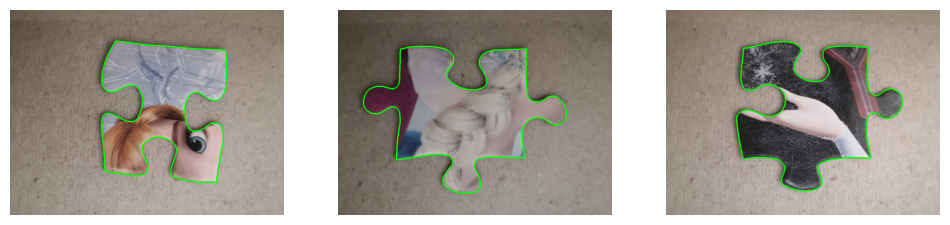

In [6]:
num_sample = 3
drawn_images = np.random.choice(len(masks), num_sample)

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    contour = all_contours[idx]
    contour_image = cv2.drawContours(image, [contour.reshape(-1, 1, 2)], 0, (0,1,0), 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(contour_image)
    plt.axis('off')

### 2. Shape Models

#### 2.1. Extract Sides

##### 2.1.1 Load Corners from json file

In [7]:
import json
with open("../assets/corners.json", "r") as file:
    names, corner_ratios = json.load(file)
    
scaled_corners = corner_ratios * np.array([width, height])

##### 2.1.2 extract_sides

In [8]:
def extract_sides(contour, corners):
    corner_indices = spatial.KDTree(contour).query(corners)[1]
    corner_coords = contour[corner_indices]
    
    # Sort coordinates according to contour
    sorted_corner_indices = np.sort(corner_indices)
    sorted_corner_coords = np.zeros_like(corner_coords)
    for i, new_i in enumerate(np.argsort(corner_indices)):
        sorted_corner_coords[new_i] = corner_coords[i]
    
    # Roll first corner to be at 0
    contour = np.roll(contour, -sorted_corner_indices[0], axis=0)
    shifted_corner_indices = sorted_corner_indices - sorted_corner_indices[0]
    
    # Split contour to sides
    side_contours = np.split(contour, shifted_corner_indices)
    
    # Join first and last items
    if len(side_contours) == 5:
        last = side_contours[-1]
        side_contours = side_contours[:-1]
        side_contours[0] = np.concatenate((last, side_contours[0]))
    
    # Append corner to end (side starts and ends with corner)
    for i in range(len(side_contours)):
        side_contours[i] = np.append(side_contours[i], [side_contours[(i+1)%4][0]], axis=0)
    
    return side_contours


##### 2.1.3 Draw sides

In [9]:
side_contours = [extract_sides(all_contours[idx], scaled_corners[idx]) for idx in range(num_images)]

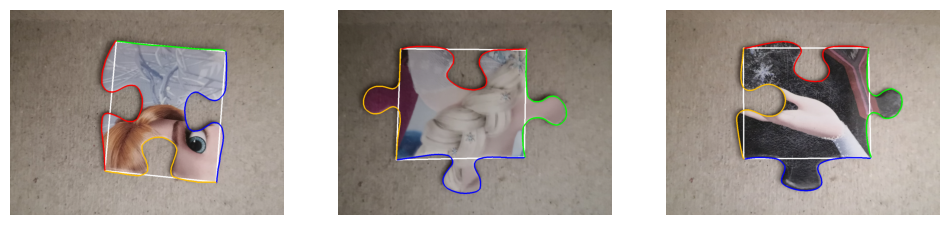

In [10]:
side_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0.75, 0)]

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    
    image_corners = scaled_corners[idx].astype(int)
    image = cv2.polylines(image, [image_corners], 1, (1,1,1), 3)
    
    for j, side in enumerate(side_contours[idx]):
        image = cv2.polylines(image, [side], 0, side_colors[j], 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(image)
    plt.axis('off')

#### 2.2 Normalise Sides

##### 2.2.1 transform_puzzle_side

In [11]:
def transform_puzzle_side(contour):
    contour = np.array(contour, dtype=np.float32)
    
    # Shift to origin
    contour -= np.mean(contour[[0, -1]], axis=0)
    
    # Scale down to unit vectors
    scale_factor = np.linalg.norm([contour[-1] - contour[0]]) / 2
    contour /= scale_factor
    
    # Rotate
    end = contour[-1]
    theta = np.arctan2(end[1], end[0]) + np.pi # + np.pi to rotate 180deg (protruding top, sunken bottom)
    
    c = np.cos(-theta)
    s = np.sin(-theta)
    rotated = (np.array([[c, -s], [s, c]], dtype=np.float32) @ contour.T).T
    
    return rotated

In [12]:
transformed_sides = [[transform_puzzle_side(side) for side in image_sides] for image_sides in side_contours]

##### 2.2.2 even_spaced_contour

In [72]:
def even_spaced_contour(contour, num_points = 64):
    # Calculate coordinates at which to evaluate [N=num_points]
    x = np.linspace(0, 1, num_points, dtype=np.float32)
    
    # Calculate the length between segments [N=len(contour) - 1]
    xp = contour[1:] - contour[:-1]
    xp = np.hypot(xp[:, 0], xp[:, 1])
    
    # Cumulative sum of lengths divided by length of contour [N=len(contour) - 1]
    xp = np.cumsum(xp, axis=0) / cv2.arcLength(contour, closed=False)
    
    # Append 0 to start of array [N=len(contour)]
    xp = np.concatenate(([0], xp), axis=0, dtype=np.float32)
    
    # Split the x and y values to interpolate separately [N=len(contour)]
    fp_0, fp_1 = np.hsplit(contour, 2)
    
    # Interpolate the x and y coordinates [N=num_points]
    y_0, y_1 = np.interp(x, xp, fp_0.flatten()), np.interp(x, xp, fp_1.flatten())
    
    # Stack interpolated values for x and y coordinates... shape=(num_points, 2)
    contour_new = np.stack((y_0.astype(np.float32), y_1.astype(np.float32)), axis=1)
        
    return contour_new

In [73]:
evenly_spaced_sides = np.array([[even_spaced_contour(side) for side in image_sides] for image_sides in transformed_sides], dtype=np.float32)

##### 2.2.3 Draw normalized sides

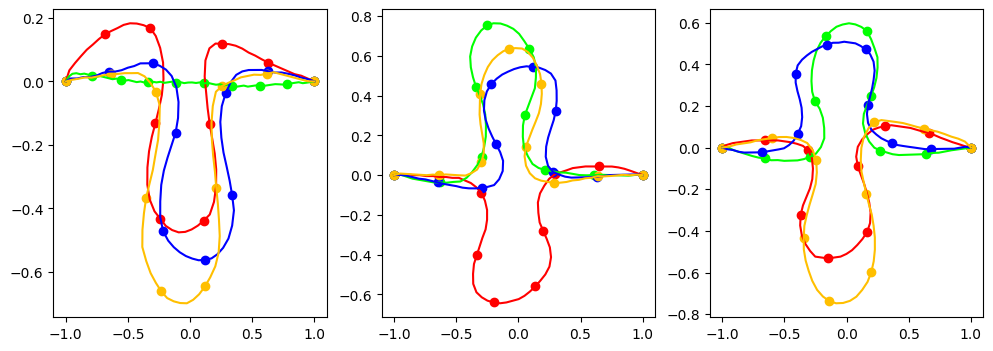

In [84]:
fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    ax = fig.add_subplot(1, num_sample, i+1)
    
    normalized = evenly_spaced_sides[idx]
    simplified = np.array([even_spaced_contour(side, 10) for side in transformed_sides[idx]], dtype=np.float32)
    
    for j, (side, dots) in enumerate(zip(normalized, simplified)):
        ax.plot(side[:, 0], side[:, 1], color=side_colors[j])
        ax.scatter(dots[:, 0], dots[:, 1], color=side_colors[j])


### 3. Match shape model

#### 3.1 is_flat_side

In [85]:
def is_flat_side(contour, min_ratio=0.9):
    # Check distance between first and last point
    contour_distance = np.linalg.norm(contour[-1] - contour[0])
    
    # Check length of contour (Imagine distance but with stretched contour)
    contour_length = cv2.arcLength(contour.reshape(-1, 1, 2), closed=False)
    
    return contour_distance / contour_length >= min_ratio

#### 3.2 Non flat array

In [212]:
non_flat_indices = np.nonzero([[not is_flat_side(side) for side in image_sides] for image_sides in evenly_spaced_sides])
non_flat_indices_uniq = np.unique(non_flat_indices)
non_flat = evenly_spaced_sides[non_flat_indices]

print(len(non_flat_indices), non_flat_indices[0].shape)
non_flat.shape


2 (164,)


(164, 64, 2)

#### 3.3 K-Nearest Neighbors

In [184]:
rotated_sides = (non_flat * (-1, -1))[:, ::-1, :]

side_features = non_flat.reshape(non_flat.shape[0], -1)
rotated_side_features = rotated_sides.reshape(rotated_sides.shape[0], -1)

knn = NearestNeighbors(n_neighbors=1, algorithm="brute")
knn = knn.fit(rotated_side_features)
distances, indices = knn.kneighbors(side_features)

indices = indices.flatten()
print(indices.shape)


(164,)


#### 3.4 Directed Graph

In [121]:
def plot_graph(V, E, seed=42):
    random.seed(seed) # graphs are randomly plotted
    np.random.seed(seed) # graphs are randomly plotted
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.draw_kamada_kawai(G, with_labels=True)
    plt.show()


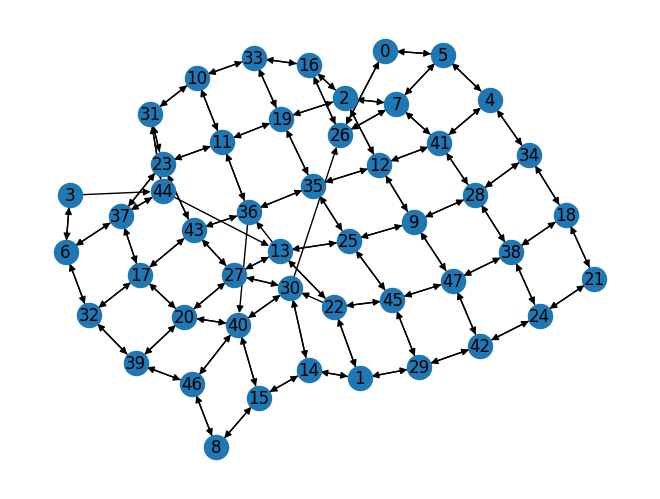

In [195]:
E = []
for i, j in enumerate(indices):
    u, v = (non_flat_indices[0][i], non_flat_indices[0][j])
    
    if u is not v:
        E.append((u, v))

plot_graph(non_flat_indices_uniq, E)

#### 3.5 Reverse matching graphs

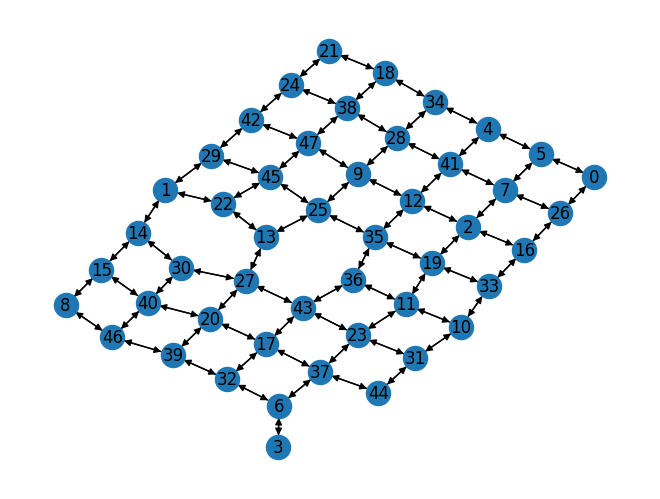

In [214]:
E_cyc = []
i_cyc = []
for i, j in enumerate(indices):
    u, v = (non_flat_indices[0][i], non_flat_indices[0][j])
    u_ = non_flat_indices[0][indices[j]]
    
    if (u is not v and u == u_):
        E_cyc.append((u, v))
        i_cyc.append(i)

plot_graph(non_flat_indices_uniq, E_cyc)

#### 3.6 Reverse matching graphs (Edge pieces)

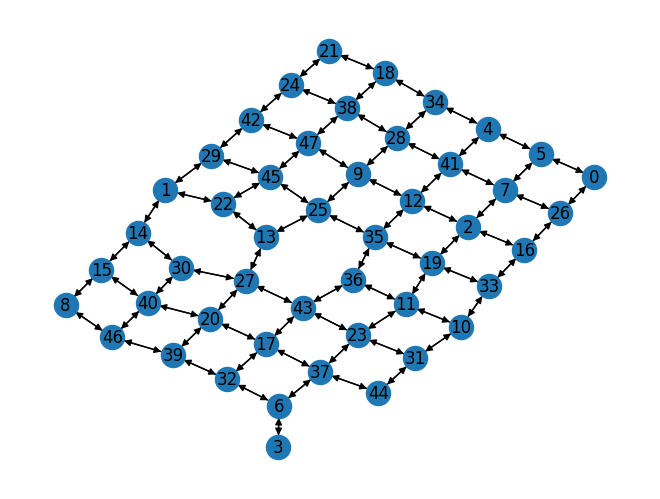

In [213]:
E_edge = []
i_edge = []
for i, j in enumerate(indices):
    u, v = (non_flat_indices[0][i], non_flat_indices[0][j])
    u_ = non_flat_indices[0][indices[j]]
    
    if (u is not v and u == u_):
        E_edge.append((u, v))
        i_edge.append(i)
        
plot_graph(non_flat_indices_uniq, E_edge)

#### 3.7 Plot matched features

In [231]:
num_features = 12
drawn_features = np.random.choice(i_cyc, num_features)

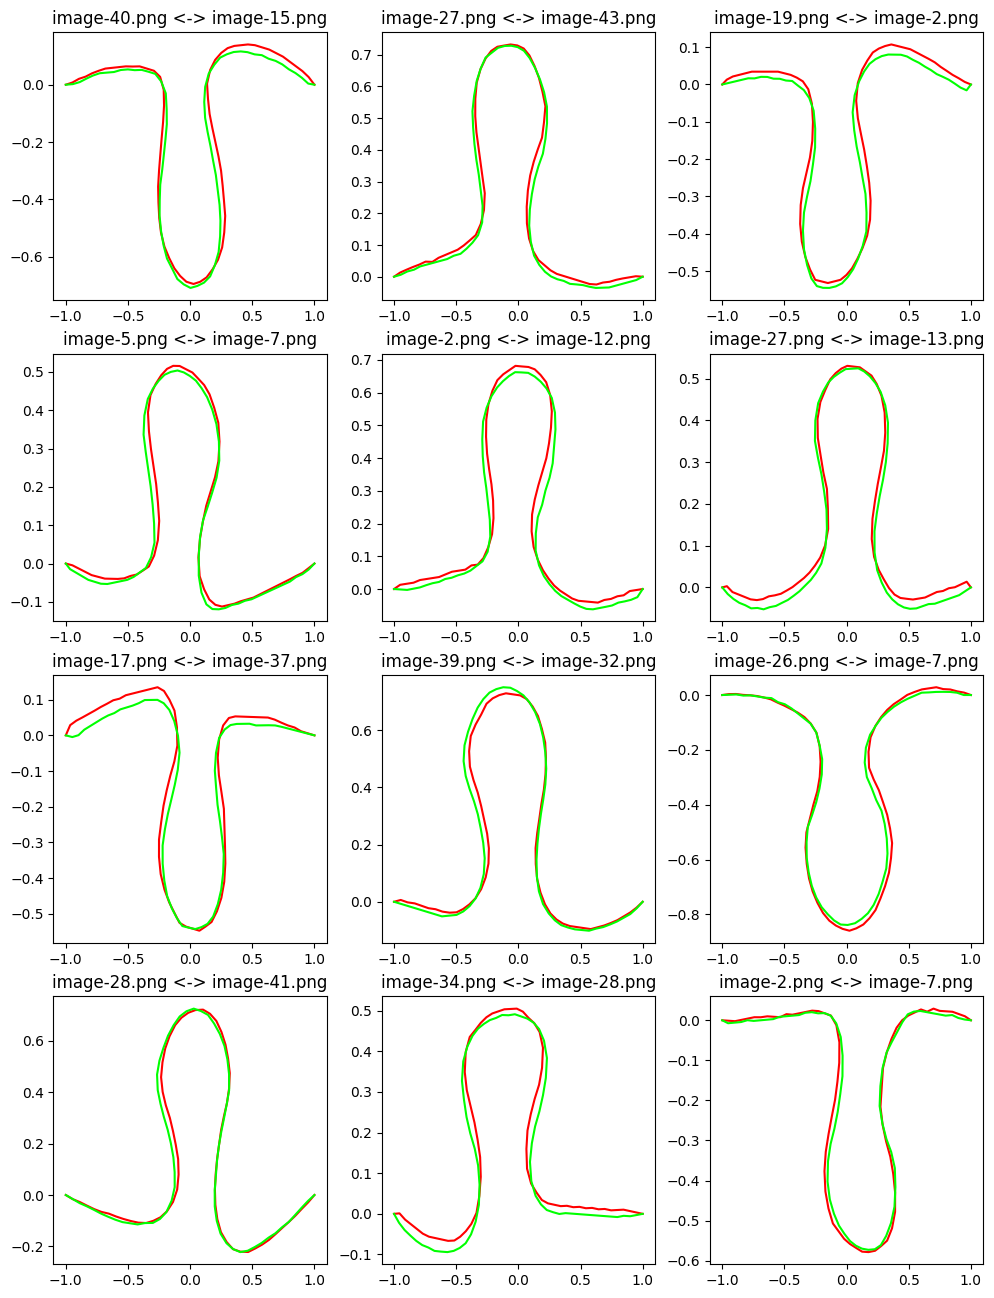

In [248]:
fig = plt.figure(figsize=(3*4, 4*4))

errors = np.zeros(num_features)

for i, idx in enumerate(drawn_features):
    ax = fig.add_subplot(4, 3, i+1)
    
    j = indices[idx]
    u_x, u_y = (non_flat_indices[0][idx], non_flat_indices[1][idx])
    v_x, v_y = (non_flat_indices[0][j], non_flat_indices[1][j])
    
    ax.set_title(f"{titles[u_x][0]} <-> {titles[v_x][0]}")
    
    u = evenly_spaced_sides[u_x, u_y]
    v = evenly_spaced_sides[v_x, v_y]
    
    v = (v * (-1, -1))[::-1, :]
    
    errors[i] = mean_squared_error(u, v)
    
    ax.plot(u[:, 0], u[:, 1], color=(1,0,0))
    ax.plot(v[:, 0], v[:, 1], color=(0,1,0))

#### 3.8 Comments

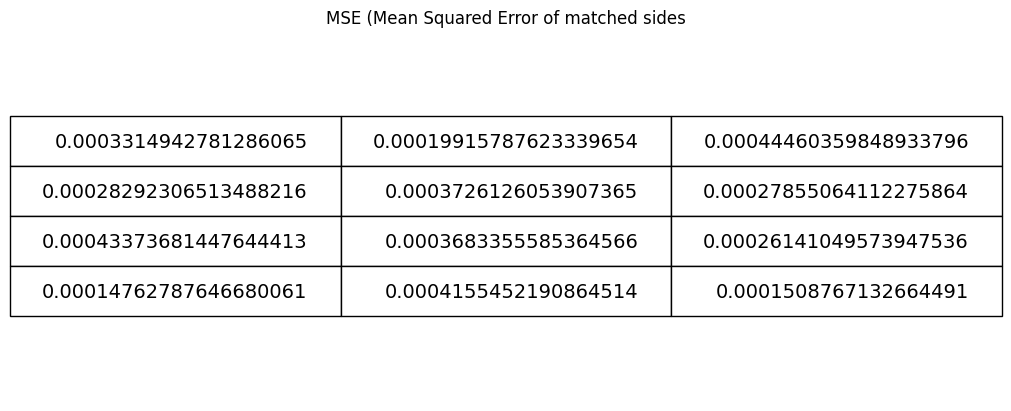

In [251]:
cell_text = errors.reshape((4, 3))
    
ax = plt.gca()
ax.set_title("MSE (Mean Squared Error of matched sides")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table = plt.table(cellText=cell_text,
                  loc='center')
table.set_fontsize(18)
table.scale(2, 3)

1. 